In [113]:
%load_ext autoreload
%autoreload 2

# Model design
import agentpy as ap
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
import seaborn as sns
import IPython
import numpy as np

from EnergyShedModel import EnergyShedModel
from plots import status_stackplot, cost_lineplot, transfer_lineplot, animation_plot

random.seed(1)

NUM_STEPS = 10

POP_SIZE = 16
GRID_SIZE = 4

SUNNY_PROB = 0.5
PERCENT_PRODUCERS = 0.75


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Grid agent

In [90]:
parameters = {"population": POP_SIZE, "steps": NUM_STEPS, "grid_size": (GRID_SIZE, GRID_SIZE), "agent_type": "grid", "sunny_prob" : SUNNY_PROB, "percent_producers": PERCENT_PRODUCERS}

model = EnergyShedModel(parameters)
results = model.run()

Completed: 10 steps
Run time: 0:00:00.007049
Simulation finished


In [ ]:
results.reporters
results.variables.EnergyShedModel

In [ ]:
fig, ax = plt.subplots()
status_stackplot(results.variables.EnergyShedModel, ax)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
cost_lineplot(results.variables.EnergyShedModel, ax=ax1)
transfer_lineplot(results.variables.EnergyShedModel, ax=ax2)
fig.suptitle("Grid Model")

In [ ]:
fig, ax = plt.subplots()
model = EnergyShedModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())

# Reflex agents

In [ ]:
parameters = {"population": POP_SIZE, "steps": NUM_STEPS, "grid_size": (GRID_SIZE, GRID_SIZE), "agent_type": "reflex", "sunny_prob" : SUNNY_PROB, "percent_producers": PERCENT_PRODUCERS}

model = EnergyShedModel(parameters)
results = model.run()

In [ ]:
results.reporters

In [ ]:
fig, ax = plt.subplots()
status_stackplot(results.variables.EnergyShedModel, ax)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
cost_lineplot(results.variables.EnergyShedModel, ax=ax1)
transfer_lineplot(results.variables.EnergyShedModel, ax=ax2)
fig.suptitle("Reflex Model")

In [ ]:
fig, ax = plt.subplots()
model = EnergyShedModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())

# Q-learning agent

In [97]:
parameters = {"population": POP_SIZE, "steps": NUM_STEPS, "grid_size": (GRID_SIZE, GRID_SIZE), "agent_type": "qlearning", "sunny_prob" : SUNNY_PROB, "percent_producers": PERCENT_PRODUCERS}

model = EnergyShedModel(parameters)
results = model.run()

Completed: 10 steps
Run time: 0:00:00.015599
Simulation finished


In [105]:
results.reporters
results.variables.EnergyShedModel

{((-1, True), 'buy'): 0,
 ((-1, True), 'sell'): 0,
 ((-1, False), 'buy'): -4.889130840168388,
 ((-1, False), 'sell'): -200.78707830516447,
 ((0, True), 'buy'): 0,
 ((0, True), 'sell'): 0,
 ((0, False), 'buy'): 0,
 ((0, False), 'sell'): 0,
 ((1, True), 'buy'): -1.4948813458690595,
 ((1, True), 'sell'): 0,
 ((1, False), 'buy'): 0,
 ((1, False), 'sell'): 0}

In [ ]:
fig, ax = plt.subplots()
status_stackplot(results.variables.EnergyShedModel, ax)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
cost_lineplot(results.variables.EnergyShedModel, ax=ax1)
transfer_lineplot(results.variables.EnergyShedModel, ax=ax2)
fig.suptitle("Q-Learning Model")

In [ ]:
fig, ax = plt.subplots()
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())

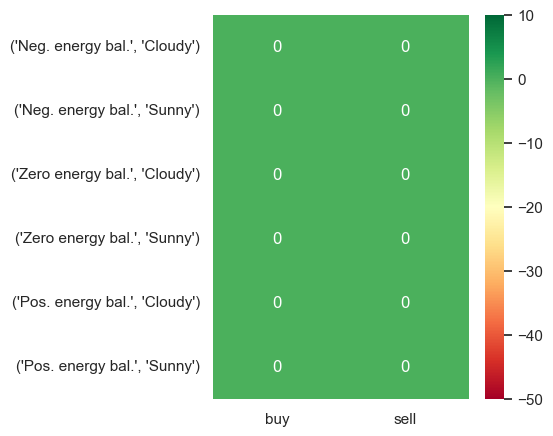

In [159]:
q_values = results.variables.EnergyShedModel["q_values"]

# Define the update function for the animation
def update(i):
    q_values = results.variables.EnergyShedModel["q_values"]
    # Extract the state and action spaces from the q-values
    state_space = sorted(set([key[0] for q_values in q_values for key in q_values.keys()]))
    action_space = sorted(set([key[1] for q_values in q_values for key in q_values.keys()]))
    q_values = q_values[i]
    # Create an empty matrix to hold the q-values
    q_values_matrix = np.zeros((len(state_space), len(action_space)))
    for j, state in enumerate(state_space):
        for k, action in enumerate(action_space):
            q_values_matrix[j, k] = q_values.get((state, action), 0)
    
    value_map = {-1: "Neg. energy bal.", 0: "Zero energy bal.", 1: "Pos. energy bal."}
    weather_map = {False: "Cloudy", True: "Sunny"}
    state_space_labels = [(value_map[val], weather_map[flag]) for val, flag in state_space]
    # Clear the previous plot and plot the new heat map
    plt.clf()
    sns.heatmap(q_values_matrix, annot=True, cmap="RdYlGn", xticklabels=action_space, yticklabels=state_space_labels, norm=colors.Normalize(vmin=-50, vmax=10))

fig = plt.figure()
plt.subplots_adjust(left=0.4, right=0.9, bottom=0.1, top=0.9)
anim = FuncAnimation(fig, update, frames=range(len(q_values)), interval=500)
IPython.display.HTML(anim.to_jshtml())

# Experiments

In [ ]:
parameters = {
    "population": ap.IntRange(100, 1000),
    "number_of_neighbors": 4,
    "network_randomness": ap.Range(0.0, 1.0),
}

sample = ap.Sample(parameters, n=128, method="saltelli", calc_second_order=False)

In [ ]:
exp = ap.Experiment(EnergyShedModel, sample, iterations=10)
results = exp.run()

In [ ]:
results.save()

In [ ]:
results

In [ ]:
results.reporters.hist();

In [ ]:
# Sensitivity Analysis

In [ ]:
results.calc_sobol()

In [ ]:
def plot_sobol(results):
    """Bar plot of Sobol sensitivity indices."""

    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by="reporter")
    si_conf_list = results.sensitivity.sobol_conf.groupby(by="reporter")

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        si = si.droplevel("reporter")
        err = err.droplevel("reporter")
        si.plot.barh(xerr=err, title=key, ax=ax, capsize=3)
        ax.set_xlim(0)

    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[])
    axs[1].tick_params(left=False)
    plt.tight_layout()


plot_sobol(results)

In [ ]:
def plot_sensitivity(results):
    """Show average simulation results for different parameter values."""

    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j]  # Flatten list

    data = results.arrange_reporters().astype("float")
    params = results.parameters.sample.keys()

    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, x_bins=15, fit_reg=False, label=y)
        ax.set_ylim(0, 1)
        ax.set_ylabel("")
        ax.legend()

    plt.tight_layout()


plot_sensitivity(results)